# 6.6: Sourcing & Analyzing Time Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

## 01. Importing

In [9]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [10]:
# Importing data
path = r'/Users/ngawangdhundup/Documents/Career Foundry Bootcamp/DM 6'
df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'insurance_cluster.csv'), index_col = 0)

In [3]:
# Configure API key

quandl.ApiConfig.api_key = 'osGzwhXAkC2ZRv-j-xnw'


In [6]:
# Federal Reserve Economic Data - Natural Rate of Unemployment
data = quandl.get('FRED/NROU')

##  Task

In [7]:
data.head(5)

Value
Date                
1949-01-01  5.255053
1949-04-01  5.261516
1949-07-01  5.268013
1949-10-01  5.274564
1950-01-01  5.281182

In [11]:
data.shape

(332, 1)

In [12]:
data.columns

Index(['Value'], dtype='object')

In [13]:
type(data)

pandas.core.frame.DataFrame

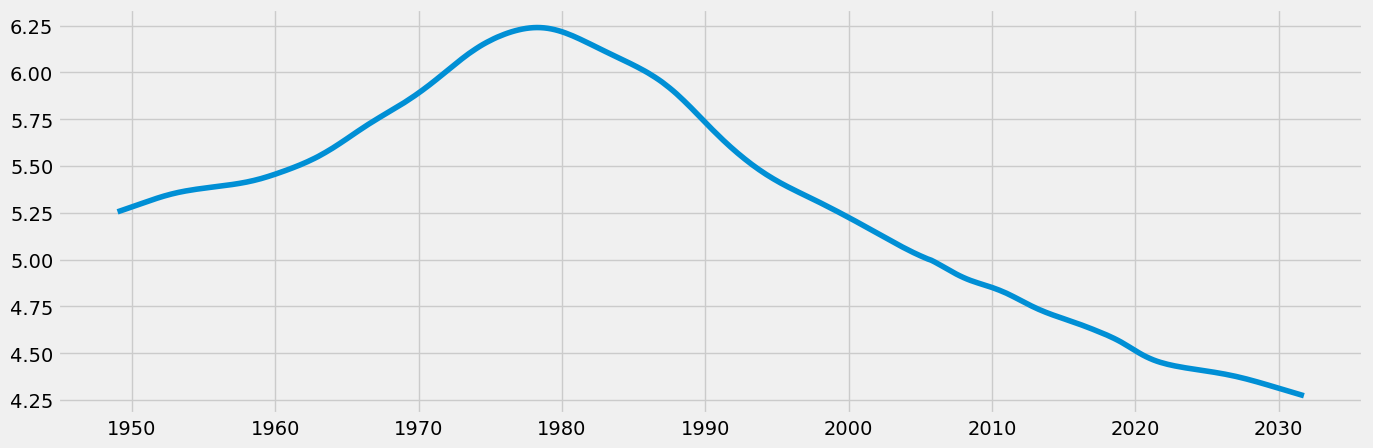

In [14]:
# Plot the data using matplotlib

plt.figure(figsize=(15,5), dpi=100)

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time series data

In [15]:
# reseting the index to use the date column as a filter

data_2 = data.reset_index()

In [16]:
data_2.head()

Date     Value
0 1949-01-01  5.255053
1 1949-04-01  5.261516
2 1949-07-01  5.268013
3 1949-10-01  5.274564
4 1950-01-01  5.281182

In [35]:
data_sub = data_2.loc[(data_2['Date'] >= '2000-01-01') & (data_2['Date'] < '2020-06-01')]

In [36]:
data_sub.shape

(82, 2)

In [37]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True) 
data_sub.head()


Value
datetime            
2000-01-01  5.224948
2000-04-01  5.214622
2000-07-01  5.204211
2000-10-01  5.193731
2001-01-01  5.183197

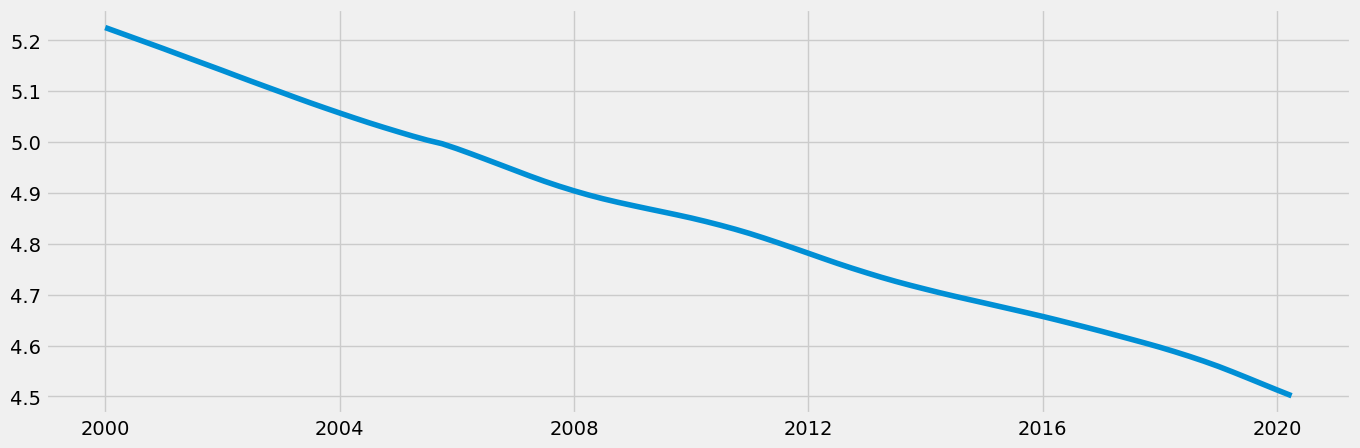

In [38]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [21]:
# Check for missing values 

data_sub.isnull().sum() 

Value    0
dtype: int64

In [22]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

0

##### I subsetted the data to be more relevent to current times and have a more modern relevency


### 3. Time-series analysis: decomposition

In [39]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [40]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

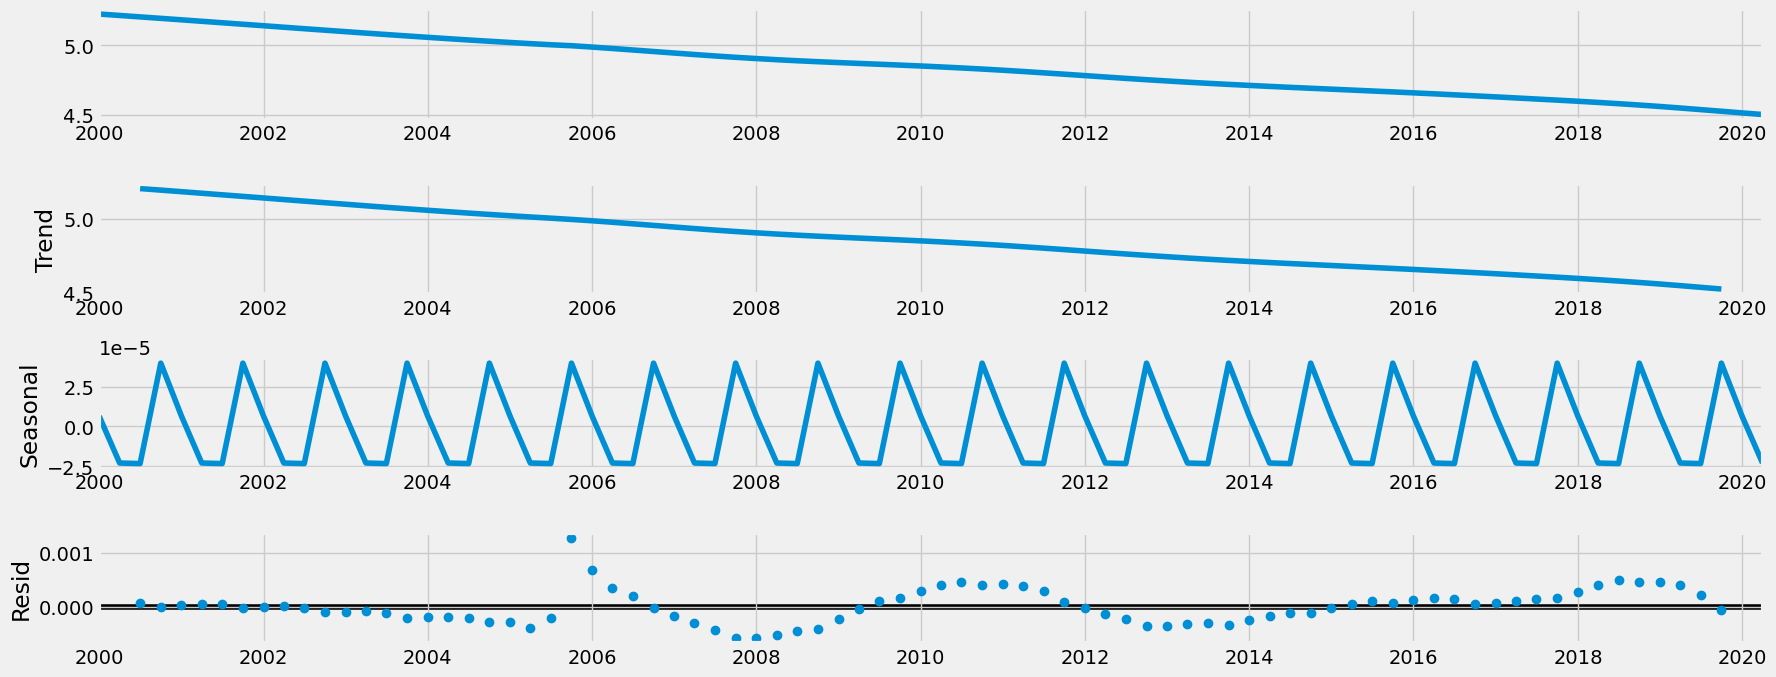

In [41]:
# Plot the separate components

decomposition.plot()
plt.show()

##### The decompostion shows there is seasonality so the data is non-stationary

### 4. Testing for stationarity

In [42]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.169108
p-value                         0.686742
Number of Lags Used             4.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


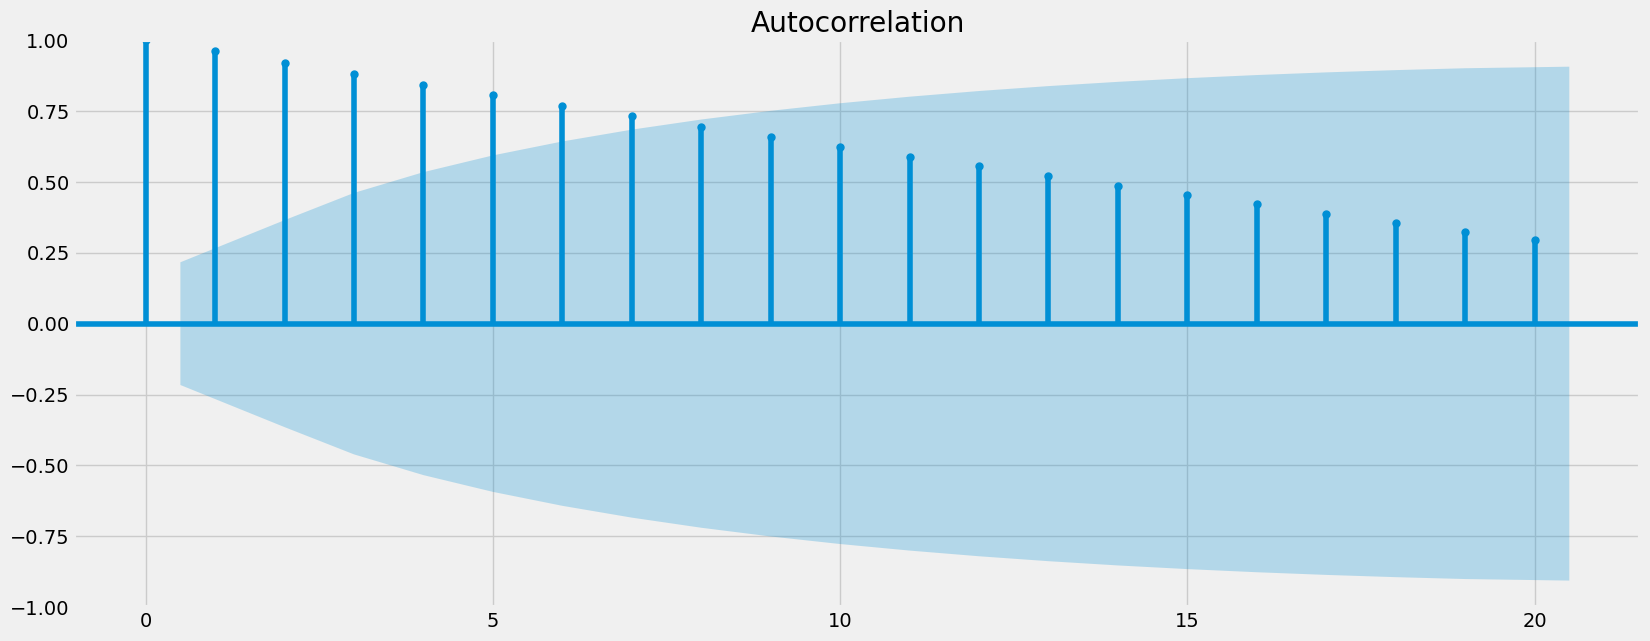

In [43]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_sub)
plt.show()

### 5. Stationarizing the Federal Reserve Economic Data

In [44]:
data_diff = data_sub - data_sub.shift(1) 

In [45]:
data_diff.dropna(inplace = True)

In [46]:
data_diff.head()

Value
datetime            
2000-04-01 -0.010326
2000-07-01 -0.010411
2000-10-01 -0.010480
2001-01-01 -0.010534
2001-04-01 -0.010583

In [47]:
data_diff.columns

Index(['Value'], dtype='object')

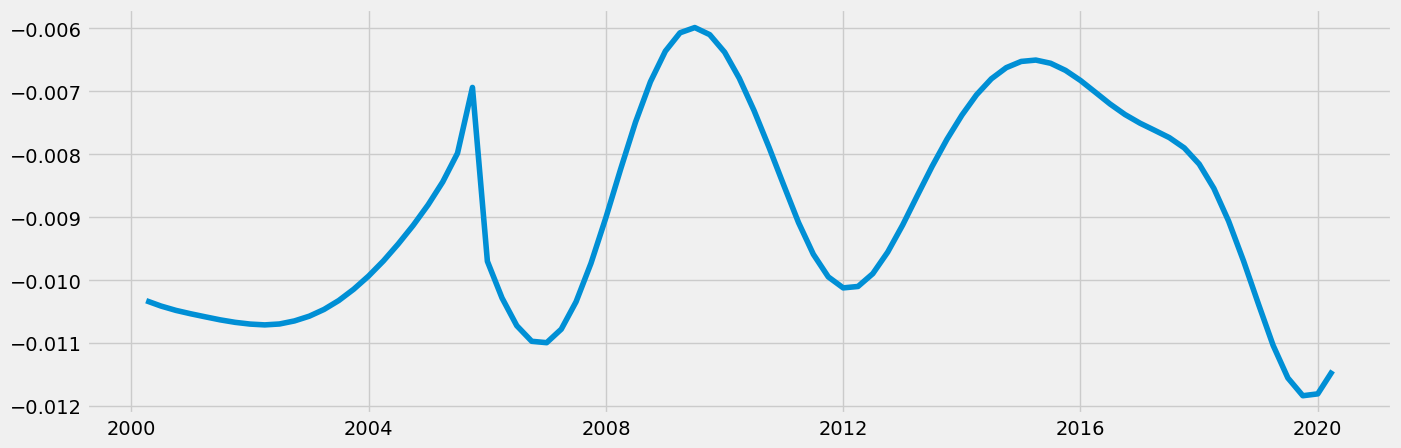

In [48]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [49]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.325195
p-value                         0.013789
Number of Lags Used             3.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


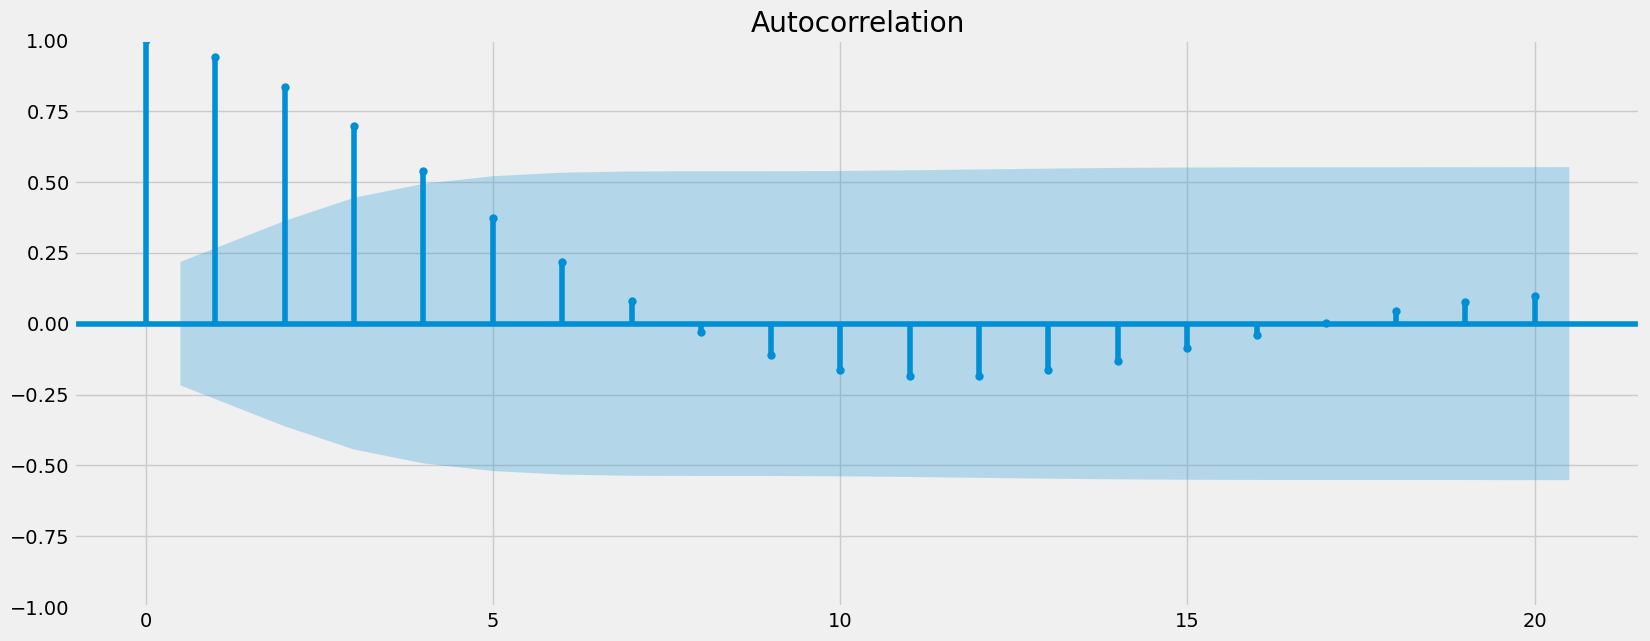

In [51]:
plot_acf(data_diff)
plt.show()

##### The p value is less than 0.05 so the test is statistically significant. The dickey fuller test is a success because the test stat is smaller than the critical values at 5 and 10 percentages. The null hypothesis is whether national unemployment rate affects medical costs. 